[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/figs_5_and_6.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2023/figs_5_and_6.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/figs_5_and_6.ipynb)

# TODO #1417

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot, markers, patches

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal
from PySDM_examples.Arabas_et_al_2023.frozen_fraction import FrozenFraction
from PySDM_examples.Arabas_et_al_2023 import make_particulator, run_simulation
from PySDM_examples.Arabas_et_al_2023.commons import FREEZING_CONSTANTS, LOGNORMAL_MODE_SURF_A, BEST_FIT_LN_S_GEOM

from open_atmos_jupyter_utils import show_plot

In [3]:
constants = FREEZING_CONSTANTS["dust"]

formulae = Formulae(
    freezing_temperature_spectrum='Niemand_et_al_2012',
    constants=constants
)

n_sd = 32
n_steps = 120
volume = 10**6 * si.m**3
droplet_volume = 3 * si.um**3 
total_particle_number = 10**15
ensemble_n = 3
T_end_min = 60

interp_kwargs = {'kind': 'linear', 'fill_value': "extrapolate"}
temperature_profiles = {
    'a': interp1d(
        x=(0,          T_end_min * si.min), 
        y=(265 * si.K, 225 * si.K),
        **interp_kwargs
    ), 
    'b': interp1d(
        x=(0,          T_end_min * si.min), 
        y=(250 * si.K, 240 * si.K),
        **interp_kwargs
    ), 
    'c': interp1d(
        x=(0,          15*si.min,  T_end_min * si.min), 
        y=(280 * si.K, 240 * si.K, 240 * si.K),
        **interp_kwargs
    ), 
    'd': interp1d(
        x=(0,          14 * si.min, 15 * si.min, 16 * si.min, T_end_min * si.min), 
        y=(270 * si.K, 270 * si.K,  225 * si.K,  270 * si.K,  270 * si.K),
        **interp_kwargs
    ), 
    'e': interp1d(
        x=(0,           15 * si.min, T_end_min * si.min), 
        y=(280 * si.K, 240 * si.K,  250 * si.K),
        **interp_kwargs
    ), 
    'f': interp1d(
        x=(0,          5 * si.min,  15 * si.min, 20 * si.min,  30 * si.min, 35 * si.min, 45 * si.min, 50 * si.min, T_end_min * si.min), 
        y=(280 * si.K, 237.5 * si.K, 280 * si.K,  237.5 * si.K, 280 * si.K,  237.5 * si.K, 280 * si.K, 237.5 * si.K, 280 * si.K),
        **interp_kwargs
    ), 
}

ff = FrozenFraction(
    volume=volume,
    droplet_volume=droplet_volume,
    total_particle_number=total_particle_number,
    rho_w=formulae.constants.rho_w,
)

A_spec = Lognormal(
    norm_factor=1,
    m_mode=LOGNORMAL_MODE_SURF_A,
    s_geom=np.exp(BEST_FIT_LN_S_GEOM)
)

In [4]:
output = {}
for lbl, temperature_profile in temperature_profiles.items():
    output[lbl] = {}
    for singular_flag in (True, False):
        output[lbl][singular_flag] = []
        for seed in range(ensemble_n):
            particulator = make_particulator(
                constants=constants,
                n_sd=n_sd, 
                dt=temperature_profile.x[-1]/n_steps,
                initial_temperature = temperature_profile(0),
                singular=singular_flag,
                seed=seed,
                shima_T_fz=formulae.freezing_temperature_spectrum.__name__,
                ABIFM_spec=A_spec,
                droplet_volume=droplet_volume,
                total_particle_number=total_particle_number,
                volume=volume,
                thaw=True
            )
            output[lbl][singular_flag].append({
                **run_simulation(particulator, temperature_profile, n_steps)
            })

In [5]:
def setup_subplots():
    fig, axes = pyplot.subplots(
        len(temperature_profiles)//2, 2,
        figsize=(12,9),
        sharex=True,
        tight_layout=True
    )
    for axss in axes:
        for ax in axss:
            ax.set_xticks((0, 15, 30, 45, T_end_min))
            ax.grid()
    for ax in (axes[-1][0], axes[-1][1]):
        ax.set_xlabel("time [min]")    
    return fig, axes

In [24]:
def plot_ff(axes, data, singular, label):
    axes.grid()
    axes.set_ylabel("       frozen fraction [1]", loc='bottom')
    axes.set_ylim(-.05,1.5)
    axes.set_yticks((0, .25, .5, .75, 1))
    axes.plot(
        np.asarray(data["products"]["t"]) / si.min,
        [ff.qi2ff(qi) for qi in data["products"]["qi"]],
        label="" if not label else "singular" if singular else "time-dependent",
        color='black' if singular else 'teal',
        marker=".",
        linewidth=.333,
        markersize=1.5
    )

def plot_T(axes, data, label=""):
    twin = axes.twinx()
    twin.set_ylabel("T [K]   ", color='red', loc='top')
    ticks = (240, 260, 280)
    twin.set_yticks(ticks=ticks, labels=[str(t) for t in ticks], color='red')
    twin.set_ylim((70, 290))
    twin.plot(
        np.asarray(data["products"]["t"]) / si.min,
        data["products"]["T"],
        color='red',
        linewidth=2,
        label=label
    )
    twin.grid()

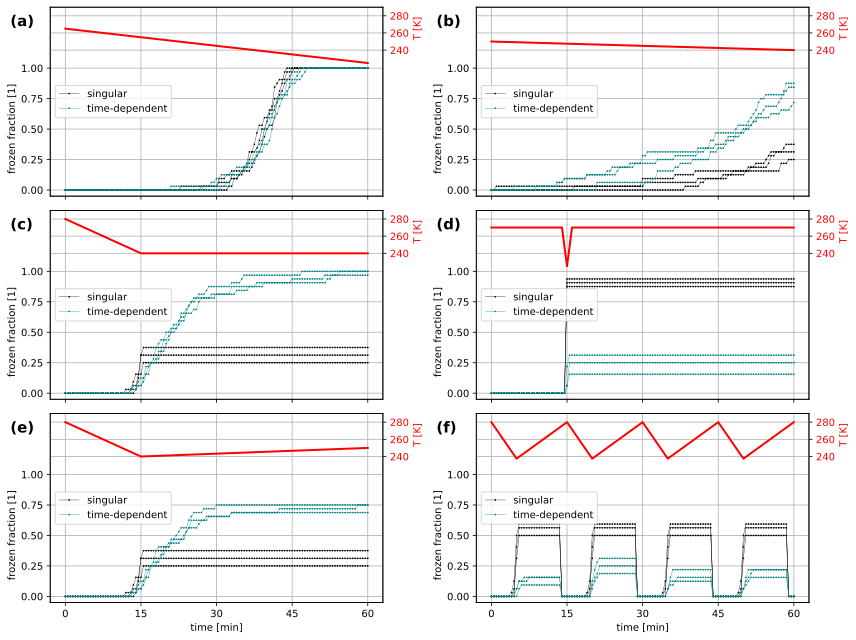

In [25]:
_, axs = setup_subplots()

for i, lbl in enumerate(temperature_profiles.keys()):
    rr, cc = i // 2, i % 2
    for singular_flag in (True, False):
        for r in range(len(output[lbl][singular_flag])):
            plot_ff(axs[rr, cc], output[lbl][singular_flag][r], singular_flag, label=r==0)
            
    plot_T(axs[rr, cc], output[lbl][singular_flag][0])
    axs[rr, cc].text(
        -.12, .9,
        '('+lbl+')',
        transform=axs[rr, cc].transAxes,
        size=15,
        weight='bold'
    )
    axs[rr, cc].legend(loc='center left')

show_plot('fig_thought_experiments.pdf')

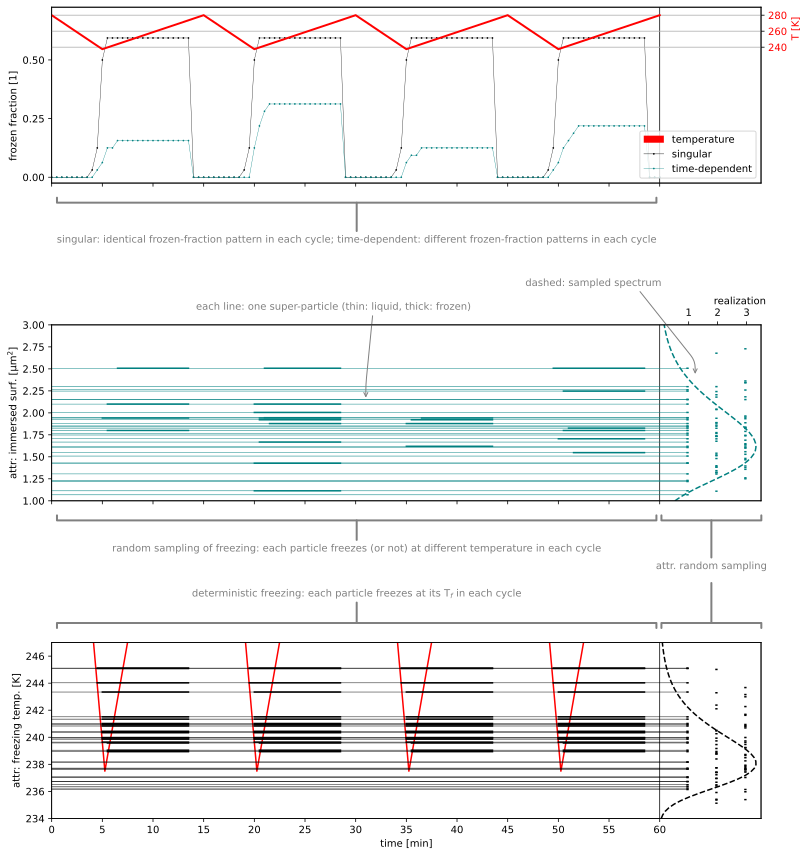

In [47]:
focus_realisation = 0
_, axs = pyplot.subplots(
    3, 1,
    figsize=(12, 12),
    sharex=True,
    tight_layout=True,
)

_SIN = 2
_CNT = 1
_TFF = 0

axs[_SIN].set_xlim(0, 70)
axs[_SIN].set_xticks(np.linspace(0, T_end_min, 13, endpoint=True))
axs[_SIN].set_xlabel("time [min]")
any_bool_value = True
time = np.asarray(output['f'][any_bool_value][0]["products"]["t"]) / si.min
dt = time[1] - time[0]

axs[_SIN].set_ylim(234, 247)
axs[_SIN].plot(
    time+dt/2,
    output['f'][True][0]["products"]["T"],
    color='red',
#     linestyle='-',
#     where='pre'
)
axs[_SIN].set_ylabel("attr: freezing temp. [K]")

axs[_CNT].set_ylabel("attr: immersed surf. [μm$^2$]")
axs[_CNT].set_ylim(1, 3)

mlt = (
    axs[_SIN].twiny(),
    axs[_CNT].twiny()
)
for axis in mlt:
    axis.set_xlim(-21, 3.5)
mlt[0].set_xticks([])
mlt[1].set_xticks((1, 2, 3))
mlt[1].set_xlabel(" " * 210 + "realization")

for axis in axs:
    axis.axvline(x=T_end_min, color='black', linewidth=.75)

for singular_flag in (True, False):
    col = 0 if singular_flag else 1
    color = 'black' if singular_flag else 'teal'
    for r in range(len(output['f'][singular_flag])):
        datum = output['f'][singular_flag][r]
        frozen = np.asarray(datum["frozen"]).T
        X = (
            datum['spectrum']["freezing temperature"] 
            if singular_flag else
            datum['spectrum']["immersed surface area"] / si.um**2
        )
        
        mlt[col].scatter(
            np.full(n_sd, r+1),
            X,
            color=color,
            s=5.5,
            marker=markers.TICKLEFT
        )        

        if r != focus_realisation:
            continue
            
        mlt[col].hlines(
            X,
            xmin=0,
            xmax=np.full(n_sd, r+1),
            color=color,
            linewidth=.5,
        )

        for i in range(n_sd):
            Xi = np.repeat(X[i], len(time))
            for frz in (True, False):
                axs[_SIN if singular_flag else _CNT].plot(
                    time,
                    np.where(frozen[i, :], Xi, np.nan) if frz else Xi,
                    color=color,
                    linewidth=1.5 if frz else .5
                )
        
def add_marginal(axes, spec, unit, color_arg):
    _y = np.linspace(*axes.get_ylim())
    _x = spec(_y * unit)
    axes.plot(
        T_end_min + _x * .95 * (axes.get_xlim()[1] - T_end_min) / max(_x),
        _y,
        color=color_arg,
        linewidth=1.5,
        linestyle='--'
    )

def T_marginal(_):
    T_space = np.linspace(*axs[_SIN].get_ylim())
    A_space = np.linspace(*axs[_CNT].get_ylim()) * si.um**2
    grid = np.meshgrid(A_space, T_space)
    sampled_pdf = formulae.freezing_temperature_spectrum.pdf(grid[1], grid[0]) * A_spec.pdf(grid[0])
    res = np.sum(sampled_pdf, axis=1)
    return res
    
add_marginal(axs[_CNT], A_spec.pdf, si.um**2, 'teal')
add_marginal(axs[_SIN], T_marginal, si.K, 'black')
                
plot_ff(axs[_TFF], output['f'][True][focus_realisation], singular=True, label=True)
plot_ff(axs[_TFF], output['f'][False][focus_realisation], singular=False, label=True)
plot_T(axs[_TFF], datum)
axs[_TFF].grid(False)

handles, labels = axs[_TFF].get_legend_handles_labels()
handles.insert(0, patches.Patch(color='red', label='temperature', linewidth=.1)) 
axs[_TFF].legend(handles=handles, loc='lower right')
axs[_TFF].set_ylim(-0.025, .725)

for lbl, xy in {
    'each line: one super-particle (thin: liquid, thick: frozen)': (31, 2.15),
    'dashed: sampled spectrum': (63.5, 2.42),
}.items():
    axs[_CNT].annotate(
        lbl,
        xy=xy, xycoords='data',
        xytext=(-170, +90), textcoords='offset points',
        color='gray',
        arrowprops={
            "arrowstyle": "->",
            "color": 'gray',
            "connectionstyle": "arc,angleA=0,armA=40,angleB=+90,armB=15,rad=7"
        },
    )

axs[_CNT].annotate(
    'random sampling of freezing: each particle freezes (or not) at different temperature in each cycle',
    xy=(0.43, -0.1), xytext=(0.43, -0.3),
    fontsize=10, ha='center', va='bottom', xycoords='axes fraction', color='gray',
    arrowprops={'arrowstyle': '-[, widthB=30, lengthB=.5', 'lw': 2.0, 'color': 'gray'}
)

axs[_SIN].annotate(
    'deterministic freezing: each particle freezes at its T$_{f}$ in each cycle',
    xy=(0.43, 1.1), xytext=(0.43, 1.25),
    fontsize=10, ha='center', va='bottom', xycoords='axes fraction', color='gray',
    arrowprops={'arrowstyle': '-[, widthB=30, lengthB=.5', 'lw': 2.0, 'color': 'gray'}
)

axs[_CNT].annotate(
    'attr. random sampling',
    xy=(0.93, -0.1), xytext=(0.93, -0.4),
    fontsize=10, ha='center', va='bottom', xycoords='axes fraction', color='gray',
    arrowprops={'arrowstyle': '-[, widthB=5, lengthB=.5', 'lw': 2.0, 'color': 'gray'}
)

axs[_SIN].annotate(
    '', xy=(0.93, 1.1), xytext=(0.93, 1.35),
    fontsize=10, ha='center', va='bottom', xycoords='axes fraction', color='gray',
    arrowprops={'arrowstyle': '-[, widthB=5, lengthB=.5', 'lw': 2.0, 'color': 'gray'}
)

axs[_TFF].annotate(
    'singular: identical frozen-fraction pattern in each cycle; time-dependent: different frozen-fraction patterns in each cycle',
    xy=(0.43, -0.1), xytext=(0.43, -0.35),
    fontsize=10, ha='center', va='bottom', xycoords='axes fraction', color='gray',
    arrowprops={'arrowstyle': '-[, widthB=30, lengthB=.5', 'lw': 2.0, 'color': 'gray'}
)

pyplot.subplots_adjust(top=.66, bottom=0, left=0, right=1)
show_plot('fig_realisations.pdf')